# Image Classification with transformers and Cleanlab

This 5-minute quickstart tutorial demonstrates how to find potential issues in image classification data. Here we use a *subset* of the [Oxford Pets](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset containing 3685 images of dogs and cats with their respective breeds as labels.

**Overview of what we'll do in this tutorial:**

- Use the [ViT model](https://huggingface.co/docs/transformers/main/model_doc/vit#transformers.ViTModel) to generate image `features`.

- Use the image features to compute out-of-sample predicted probabilities, `pred_probs`, via cross-validation and Logistic Regression.

- Use these predictions and features to find issues in the dataset like mislabeled examples, near duplicates, outliers, blurry, etc via cleanlab's `Datalab` class.

<div class="alert alert-info">
Quickstart
<br/>
    
Already have a `model`? Run cross-validation to get out-of-sample `pred_probs` and then the code below to find any potential label errors in your dataset.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python
from cleanlab import Datalab

lab = Datalab(data=your_dataset, label_name="column_name_of_labels")
lab.find_issues(pred_probs=your_pred_probs, issue_types={"label":{}})

lab.get_issues("label")
```
    
</div>
</div>

## 1. Install and import required dependencies

You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install matplotlib torch torchvision datasets
!pip install "cleanlab[datalab, image]"
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (this cell is hidden from docs.cleanlab.ai).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)
# Package versions used: matplotlib==3.5.1 torch==1.11.0

dependencies = ["cleanlab", "matplotlib", "torch", "torchvision", "datasets"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install "cleanlab"  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

# Suppress benign warnings: 
import warnings 
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [1]:
from transformers import AutoImageProcessor, ViTModel
import torch
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
import numpy as np
from cleanlab import Datalab
import matplotlib.pyplot as plt

## 2. Preprocessing the dataset
For simplicity, we use the huggingface dataset

In [2]:
dataset = load_dataset("pcuenq/oxford-pets", split='train')
# Constructing a subset of the dataset
dataset = dataset.train_test_split(test_size=0.5, seed=0)['train']

Found cached dataset parquet (/home/sanjana/.cache/huggingface/datasets/pcuenq___parquet/pcuenq--oxford-pets-43375e644eed3d52/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached split indices for dataset at /home/sanjana/.cache/huggingface/datasets/pcuenq___parquet/pcuenq--oxford-pets-43375e644eed3d52/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-cf235b0d7d17fe8b.arrow and /home/sanjana/.cache/huggingface/datasets/pcuenq___parquet/pcuenq--oxford-pets-43375e644eed3d52/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-66d194bf8c33930d.arrow


View the columns in the dataset

In [3]:
dataset.features

{'path': Value(dtype='string', id=None),
 'label': Value(dtype='string', id=None),
 'dog': Value(dtype='bool', id=None),
 'image': Image(decode=True, id=None)}

Sample image from the dataset with its label

label: Bombay


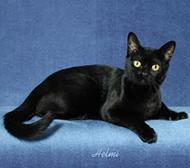

In [4]:
print(f"label: {dataset[0]['label']}")
dataset[0]['image']

In [5]:
# Create label and id mappings
labels = sorted(list(set(dataset['label'])))
id2label, label2id = {}, {}
for idx, label in enumerate(labels):
    id2label[idx] = label
    label2id[label] = idx


# Convert label str to id
def convert_label2id(example):
    example['label'] = label2id[example['label']]
    return example


dataset = dataset.map(convert_label2id)

Loading cached processed dataset at /home/sanjana/.cache/huggingface/datasets/pcuenq___parquet/pcuenq--oxford-pets-43375e644eed3d52/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-4a309aca9b18004e.arrow


## 3. Generate features for images

In [6]:
# Using a vision transformer model trained on Imagenet dataset
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
features = []

with torch.no_grad():
    for image in tqdm(dataset['image']):
        image = image.convert("RGB")
        inputs = image_processor(image, return_tensors="pt")
        inputs.to(device)
        
        outputs = model(**inputs)
        
        pooler_output = outputs.pooler_output
        
        # Using last layer as features
        features.append(pooler_output.cpu())


features = torch.vstack(features).numpy()

  0%|          | 0/3695 [00:00<?, ?it/s]

## 4.  Compute out-of-sample predicted probabilities

In [7]:
model = LogisticRegression(max_iter=400)
pred_probs = cross_val_predict(model, features, dataset['label'], method="predict_proba")
print(f"Held out accuracy: {(np.argmax(pred_probs, axis=1) == dataset['label']).mean()}")

Held out accuracy: 0.9223274695534506


## 5. Use cleanlab to find issues

Based on the images, given labels, image features and out-of-sample predicted probabilities, cleanlab can quickly help us identify all kinds issues in our dataset. 

Here, we use cleanlab's `Datalab` to find potential issues in our data. `Datalab` has several ways of loading the data. In this case, we’ll simply use the huggingface dataset and provide the names of label and image columns as `label_name` and `image_key` respectively. Once we create the `Datalab` object with the huggingface dataset, we can then provide the model's predicted probabilities and image features that we obtained earlier. By doing so, we'll be able to detect and address potential issues in our dataset. Let's dive into the step-by-step process!

In [8]:
lab = Datalab(data=dataset, label_name="label", image_key="image")
lab.find_issues(pred_probs=pred_probs, features=features)

Finding label issues ...


Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/3695 [00:00<?, ?it/s]


Audit complete. 207 issues found in the dataset.


After the audit is complete, we can view a summary of the results and information regarding the issues using Datalab's `report` method.

Here is a summary of the different kinds of issues found in the data:

      issue_type  num_issues
           label         101
         outlier          53
  near_duplicate          39
          blurry           9
       grayscale           3
            dark           2
         non_iid           0
           light           0
 low_information           0
odd_aspect_ratio           0
        odd_size           0

Dataset Information: num_examples: 3695, num_classes: 37


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 101
Overall dataset quality in terms of this issue: 0.9727

Examples representing most severe instances of this issue:
      is_label_issue  label_score  given_label  predicted_label
2616            True     0.000046            1                5
2698        

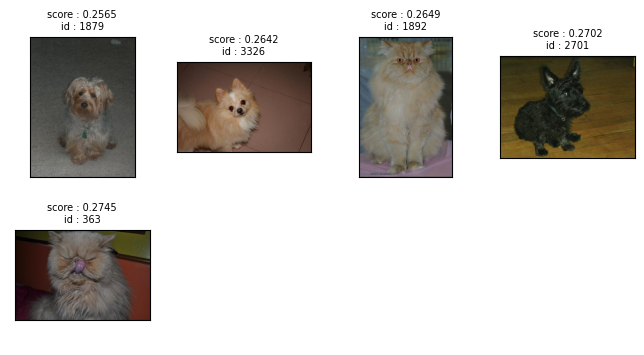

--------------------- grayscale images ---------------------

Number of examples with this issue: 3
Examples representing most severe instances of this issue:



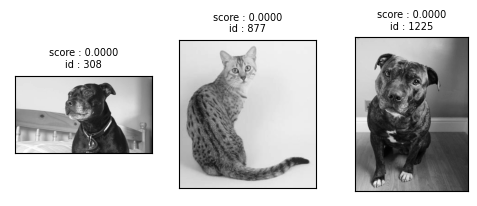

----------------------- dark images ------------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:



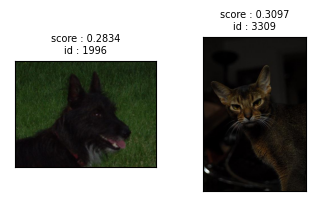

In [9]:
lab.report()

## 6. Review different issue types

This section is dedicated to visualizing the different types of issues found in the dataset.

Generally, this involves:

1. Querying one of the `issues` dataframes to find examples that are considered to have an issue or not.

2. Sorting the filtered results by their associated issue quality scores in ascending order.

3. Examining the sorted results and creating subplots of the images with any relevant information or context.

We define a function, `make_image_plot` to visualize images, and provide some context to images that might have issues.

In [10]:
def make_image_plot(ax, img, label=None, additional_info=None):
    title = ""
    if label is not None:
        title = 'Label: {}'.format(id2label[label])

    if additional_info is not None:
        title += '\n' + additional_info

    if title:
       ax.set_title(title)
    ax.axis("off")
    ax.imshow(img, cmap="gray")

### Label issues

In this section, we focus on visualizing examples in the dataset that have label errors. Label errors occur when the given label for an image is incorrect, usually due to mislabeling during dataset creation. 

We filter the `label_issues` DataFrame to find examples that are considered to have label errors.

Then, we sort the filtered results by their label quality score in ascending order, where examples with the lowest scores are more likely to have label errors.

In [11]:
label_issues = lab.get_issues("label")

labels_df = (
    label_issues
    .query("is_label_issue")
    .sort_values("label_score", ascending=True)
    
)
labels_df.head(10)

is_label_issue  label_score  given_label  predicted_label
2616            True     0.000046            1                5
2698            True     0.000050           13               12
3041            True     0.000657           30               16
1746            True     0.001463           10                2
3026            True     0.001623           14               15
1226            True     0.003360            8                2
386             True     0.003715           36               22
1516            True     0.004322           34               32
3551            True     0.004891           16               12
908             True     0.005542            4                3

We define a `plot_label_issues` function to visualize the examples with label errors. This function:

1. Retrieves the image, given label, and predicted label based on the row index.

2. Creates a plot for the image using the `make_image_plot` function with the given label and additional information about the predicted label.

Finally, we apply the `plot_label_issues` function to each row of the filtered and sorted results.

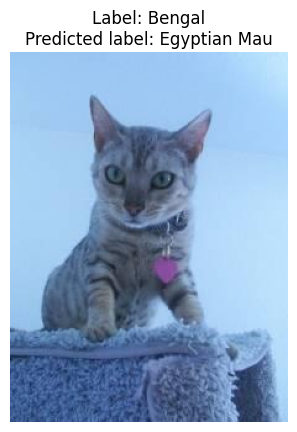

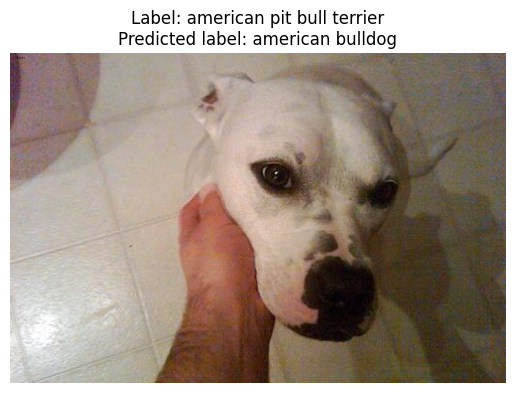

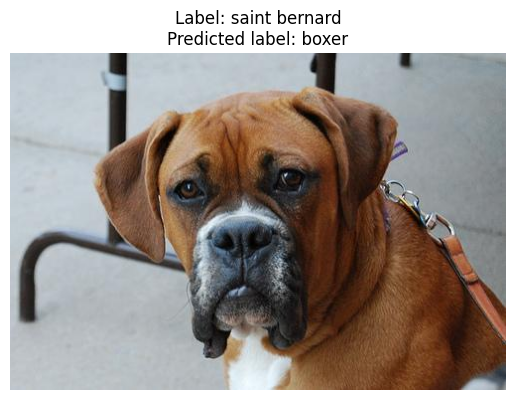

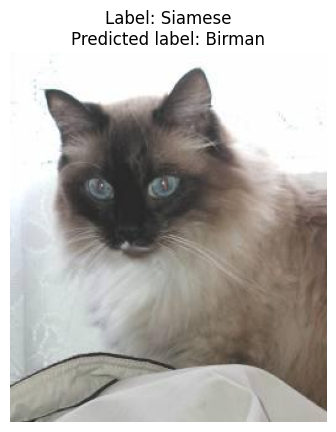

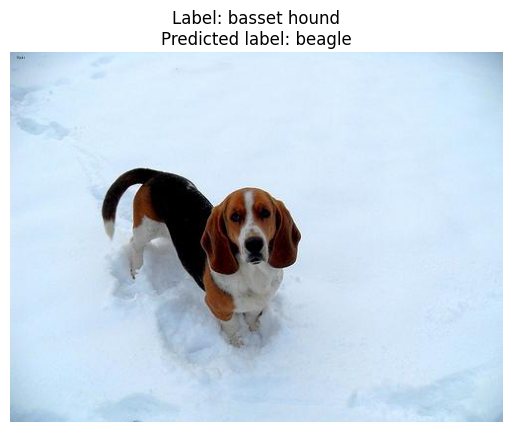

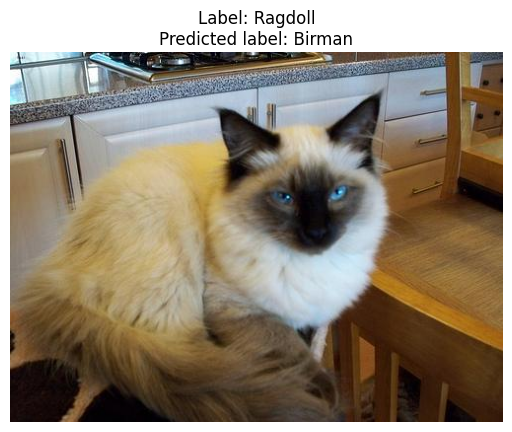

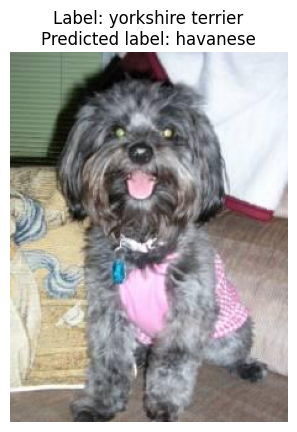

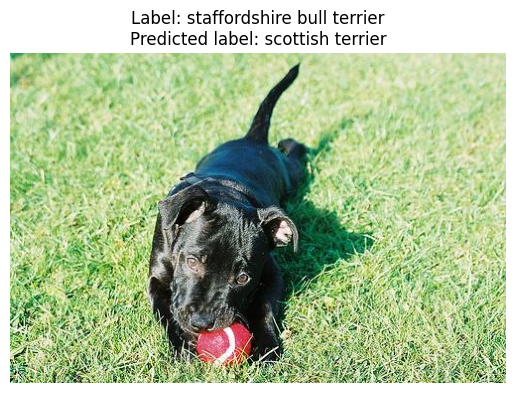

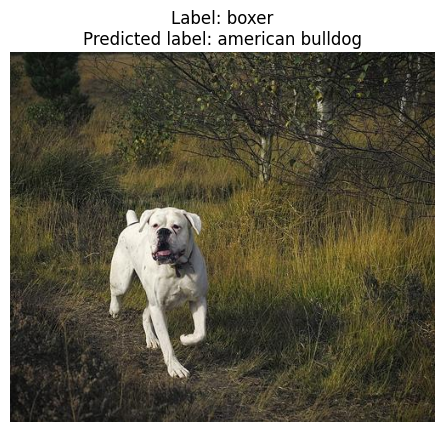

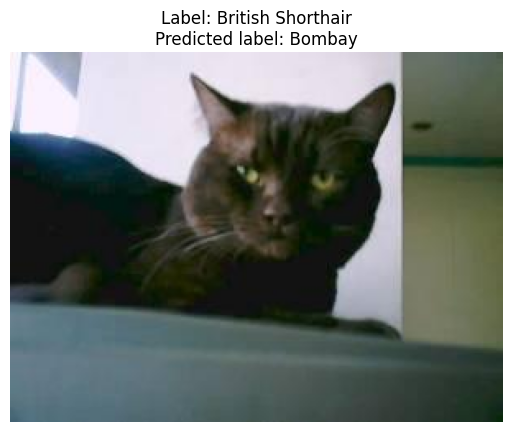

In [12]:
def plot_label_issues(row):
    idx = row.name
    image = dataset[idx]["image"]
    label = label_issues.loc[idx]["given_label"]
    predicted_label = label_issues.loc[idx]["predicted_label"]

    ax = plt.subplot(1, 1, 1)
    additional_info = f"Predicted label: {id2label[predicted_label]}"
    
    make_image_plot(ax, image, label, additional_info=additional_info)
    plt.show()

labels_df.head(10).apply(plot_label_issues, axis=1)
plt.show()

## Near duplicate issues

In this section, we display examples from the dataset that are considered to be nearly duplicated.
The `near_duplicate_issues` DataFrame tells use which examples are considered to have near duplicates, and we can sort them via the `near_duplicate_score` which quantifies how severe this issue is for each image (lower values indicate more severe intances of a type of issue).

This allows us to visualize examples in the dataset that are considered near duplicates, along with their near-duplicate counterparts.

In [13]:
near_duplicate_issues = lab.get_issues("near_duplicate")

near_duplicate_df = (
    near_duplicate_issues
    .query("is_near_duplicate_issue")
    .sort_values("near_duplicate_score", ascending=True)
)

near_duplicate_df.head()

is_near_duplicate_issue  near_duplicate_score near_duplicate_sets  \
3241                     True          0.000000e+00              [1907]   
2104                     True          0.000000e+00              [1175]   
1175                     True          0.000000e+00              [2104]   
1907                     True          0.000000e+00              [3241]   
883                      True          1.192093e-07              [1480]   

      distance_to_nearest_neighbor  
3241                  0.000000e+00  
2104                  0.000000e+00  
1175                  0.000000e+00  
1907                  0.000000e+00  
883                   1.192093e-07

We define a `plot_near_duplicate_images` function that takes a row from the `near_duplicate_issues` DataFrame as input. This function:

1. Retrieves the original image and its given label based on the row index.

2. Creates a subplot for the original image and each of its near duplicates.

To avoid cluttering the notebook with the same images, we add some logic for tracking previously displayed images and mainly displaying new images.

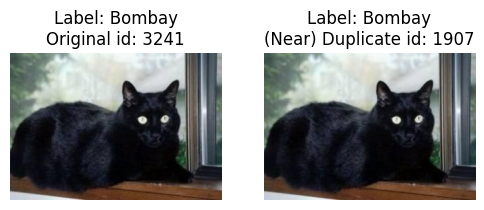

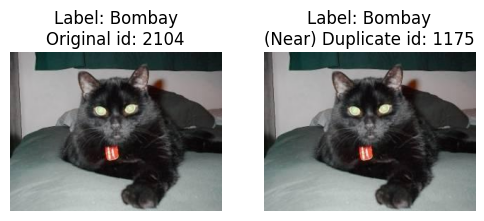

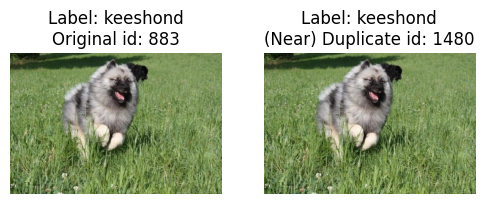

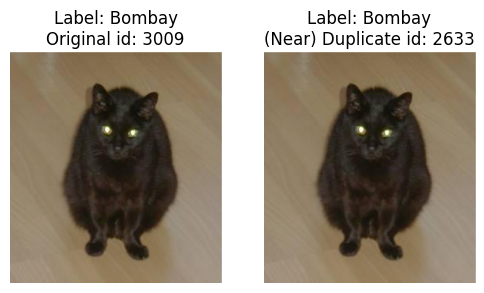

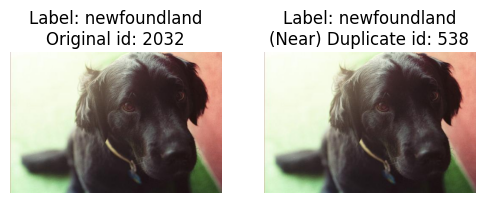

In [14]:
seen_ids = set()

def plot_near_duplicate_images(row):
    label_issues = lab.get_issues("label")
    
    def get_image_and_given_label(idx):
        image = dataset[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        return image, label

    img1_idx = row.name
    if img1_idx in seen_ids:
        return

    duplicate_images = row.near_duplicate_sets
    # how many near duplicates have we seen so far?
    seen_near_duplicates = seen_ids.intersection(duplicate_images)
    # if we have seen all near duplicates, we can skip the rest
    if len(seen_near_duplicates) == len(duplicate_images):
        return
    
    # If the set has more than 5 near duplicates, at least half of them should be new
    if len(duplicate_images) > 5 and len(seen_near_duplicates) > len(duplicate_images) / 2:
        return

    num_figures = len(duplicate_images) + 1
    _, ax = plt.subplots(1, num_figures, figsize=(num_figures * 3, 3))
    original_image, label = get_image_and_given_label(img1_idx)
    make_image_plot(ax[0], original_image, label, additional_info=f"Original id: {img1_idx}")

    seen_ids.add(img1_idx)
    
    
    for i, duplicate_image in enumerate(duplicate_images):
        img2_idx = int(duplicate_image)
        if True:
            img2, label2 = get_image_and_given_label(img2_idx)
            is_near_duplicate = near_duplicate_issues.loc[img2_idx]["is_near_duplicate_issue"]
            additional_info = ""
            if is_near_duplicate:
                additional_info = f"(Near) Duplicate id: {img2_idx}"
            make_image_plot(ax[i + 1], img2, label2, additional_info=additional_info)
            seen_ids.add(img2_idx)

near_duplicate_df.head(10).apply(plot_near_duplicate_images, axis=1)
plt.show()

## Outlier issues

In this section, we focus on reviewing atypical examples in the dataset. These are examples that are significantly different from the majority of the dataset, which may have an outsized impact on models fit to this data.

Similarly to the previous section, we filter the `outlier_issues` DataFrame to find examples that are considered to be outliers. We then sort the filtered results by their outlier quality score in ascending order, where examples with the lowest scores appear least typical based on the rest of the dataset.

In [15]:
outlier_issues = lab.get_issues("outlier")

outliers_df = (
    outlier_issues
    .query("is_outlier_issue")
    .sort_values("outlier_score", ascending=True)
)
outliers_df.head(10)

is_outlier_issue  outlier_score
1927              True       0.583598
2969              True       0.611170
3546              True       0.612333
493               True       0.626408
2739              True       0.627840
1529              True       0.628330
3208              True       0.630315
3023              True       0.639206
2258              True       0.640426
3661              True       0.645793

To visualize the most anomalous examples, we:

We define a `plot_outlier_issues` function to visualize the examples that are most anomalous. This function:
that takes a row from the `outlier_issues` DataFrame as input. This function:

1. Retrieves the image, given label and sampled images from the same class, used for comparison.

2. Creates a subplot for the original image and the sampled images.

3. Uses the `make_image_plot` function to display the images with additional information about their labels.

The `plot_outlier_issues` function is applied to each row of the filtered and sorted results.

By visualizing these anomalous examples with some additional context, we can gain insights into the dataset's diversity and the potential challenges that these unusual examples may pose during model training and evaluation.

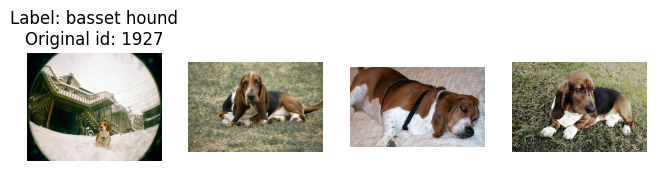

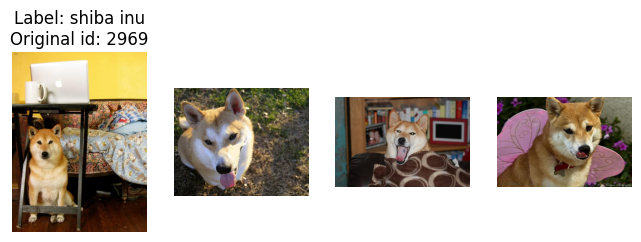

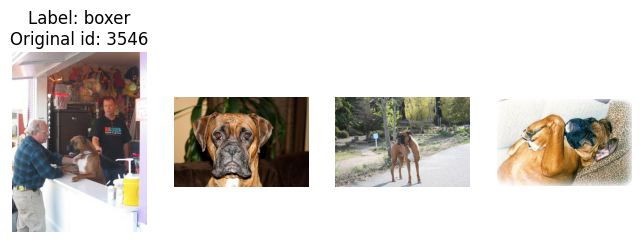

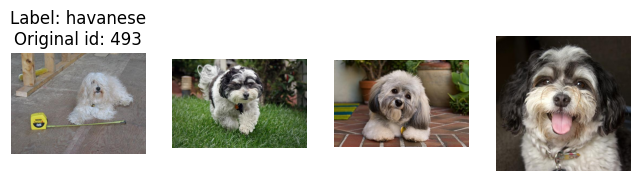

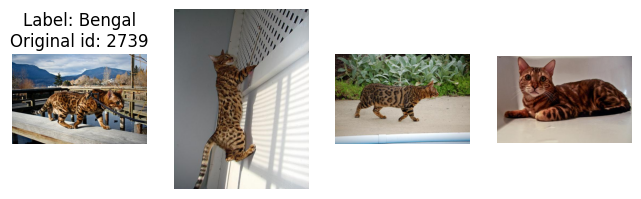

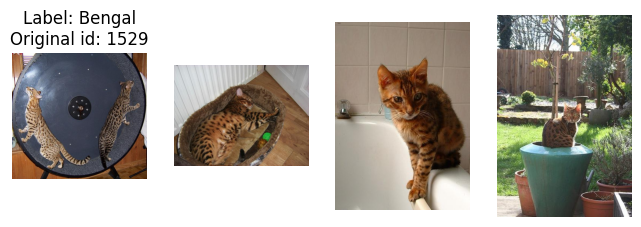

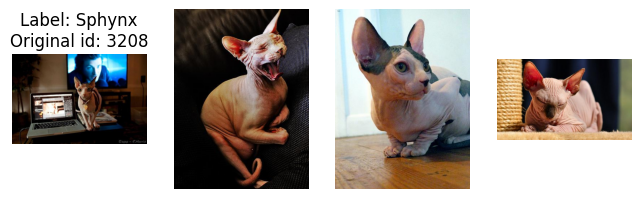

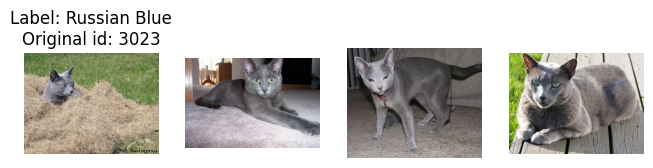

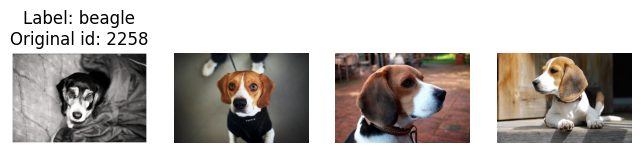

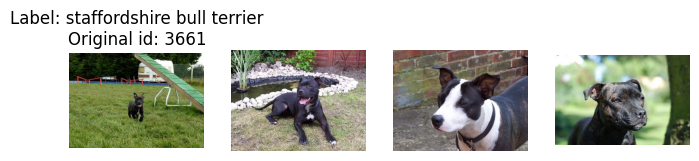

In [16]:
def plot_outlier_issues(row):

    label_issues = lab.get_issues("label")
    N_comparison_images = 3
    
    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = label_issues.join(outlier_issues).query("given_label == @label and not is_outlier_issue").index
        non_outlier_indices_excluding_current = non_outlier_indices[non_outlier_indices != index]

        sampled_indices = np.random.choice(non_outlier_indices_excluding_current, number_of_samples, replace=False)

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][:N_comparison_images]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset[int(i)]["image"] for i in top_label_indices]

        return sampled_images


    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset[idx]["image"]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[:N_comparison_images]
        
        return image_from_dataset, corresponding_label, comparison_images


    idx = row.name
    image, label, comparison_images = get_image_given_label_and_samples(idx)
    _, ax = plt.subplots(1, N_comparison_images+1, figsize=(8, 5))


    make_image_plot(ax[0], image, label, additional_info=f"Original id: {idx}")
    for i, comparison_image in enumerate(comparison_images):
        make_image_plot(ax[i + 1], comparison_image)
    plt.show()

outliers_df.head(10).apply(plot_outlier_issues, axis=1)
plt.show()

## Image specific issues

In this section, we focus on visualizing examples in the dataset that which have issues related solely to the images like blurry, dark, light images.

### Blurry images
We filter the `blurry_issues` DataFrame to find examples that are considered to be blurry

Then, we sort the filtered results by their blurry score in ascending order, where examples with the lowest scores are more likely more blurry than others.

We follow the above procedure for all image specific issues.


In [17]:
blurry_issues = lab.get_issues("blurry")

blurry_df = (
    blurry_issues
    .query("is_blurry_issue")
    .sort_values("blurry_score", ascending=True)
)
blurry_df.head(10)

blurry_score  is_blurry_issue
1879      0.256460             True
3326      0.264244             True
1892      0.264918             True
2701      0.270173             True
363       0.274495             True
713       0.275340             True
3123      0.279333             True
244       0.284881             True
2261      0.285461             True

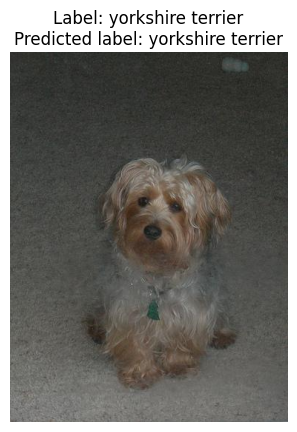

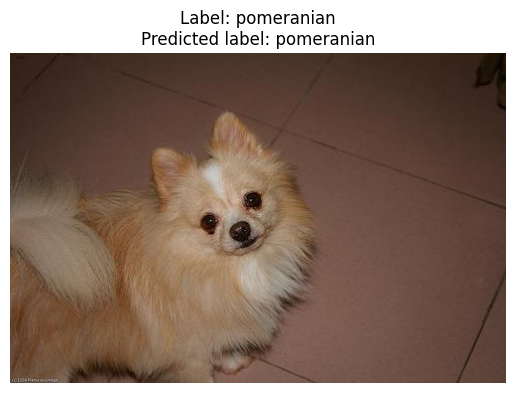

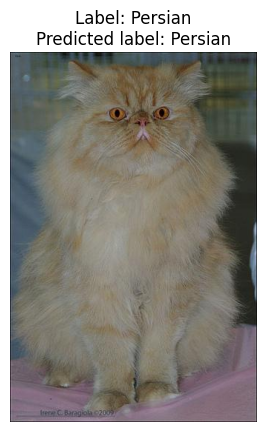

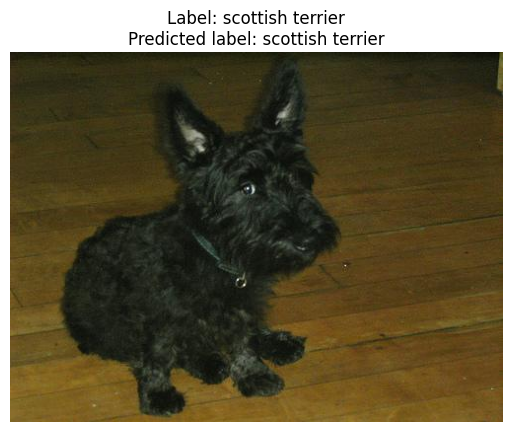

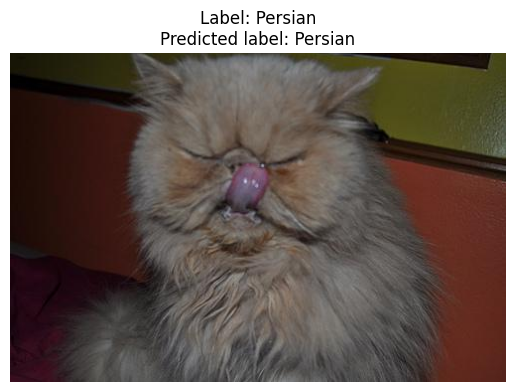

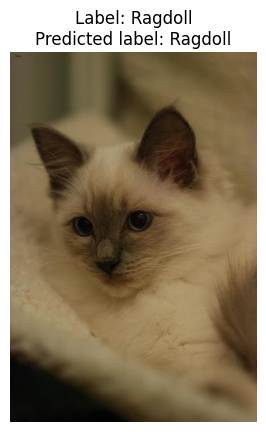

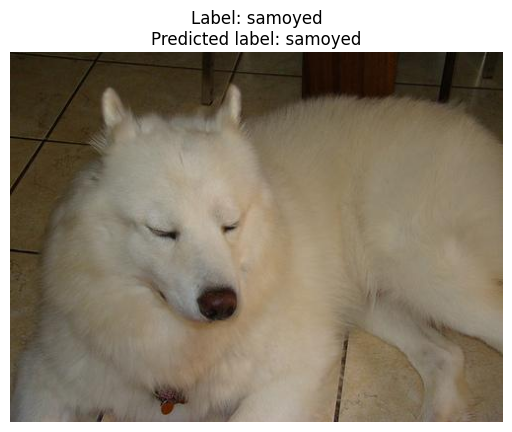

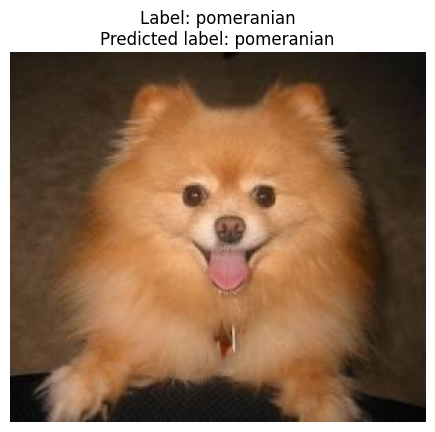

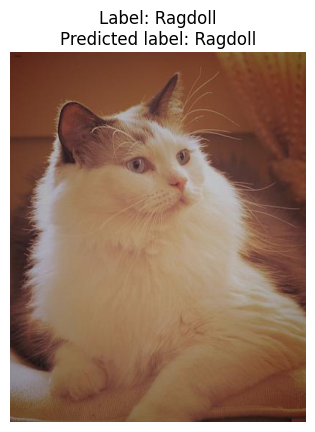

In [18]:
def plot_image_issues(row):
    idx = row.name
    image = dataset[idx]["image"]
    label = label_issues.loc[idx]["given_label"]

    ax = plt.subplot(1, 1, 1)
    
    make_image_plot(ax, image, label)
    plt.show()

blurry_df.head(10).apply(plot_label_issues, axis=1)
plt.show()

### Dark images

In this section, we show images that are too dark as identified by Cleanlab.

In [19]:
dark_issues = lab.get_issues("dark")

dark_df = (
    dark_issues
    .query("is_dark_issue")
    .sort_values("dark_score", ascending=True)
)
dark_df.head(10)

dark_score  is_dark_issue
1996    0.283366           True
3309    0.309715           True

Sometimes it can be difficult to annotate the images correctly because of the quality of image. Below is an example of an image that is too dark which makes it difficult to correctly discern the label by both model and humans.

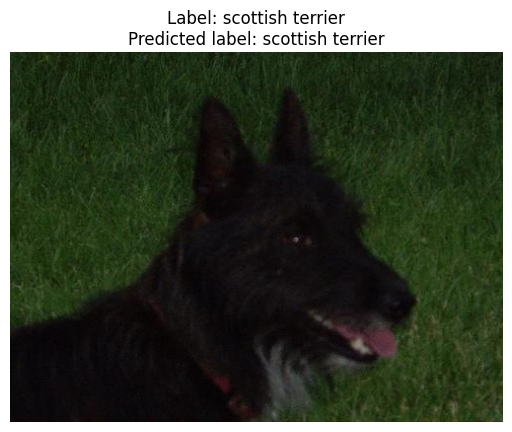

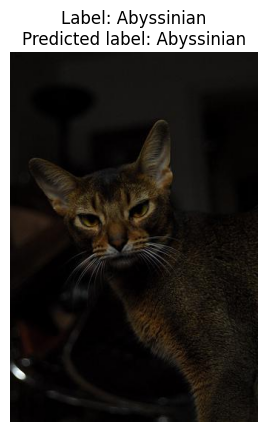

In [20]:
dark_df.head(10).apply(plot_label_issues, axis=1)
plt.show()

## Grayscale images

In this section, we show grayscale images.

In [21]:
grayscale_issues = lab.get_issues("grayscale")

grayscale_df = (
    grayscale_issues
    .query("is_grayscale_issue")
    .sort_values("grayscale_score", ascending=True)
)
grayscale_df.head(10)

dark_score  is_dark_issue
1996    0.283366           True
3309    0.309715           True

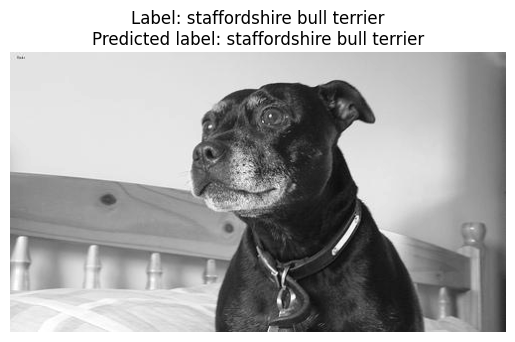

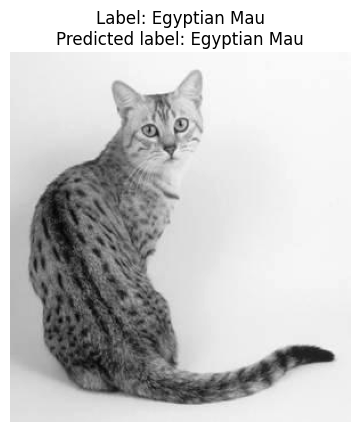

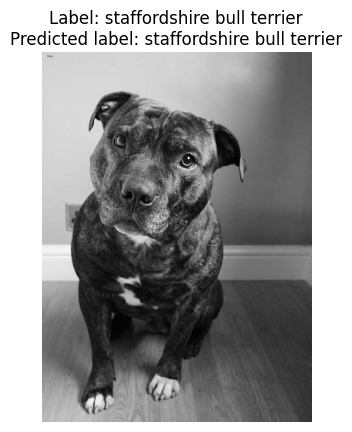

In [22]:
grayscale_df.head(10).apply(plot_label_issues, axis=1)
plt.show()